In [2]:
import pandas as pd

1. 불면증 데이터 전처리

In [36]:
# 원본 불면증 csv 파일 읽기
insomnia = pd.read_csv('data2/지역별 불면증 진료현황(2019년~2023년).csv', encoding='cp949', header=1)

In [37]:
# 첫 번째, 두 번째 컬럼명을 각각 '시도', '시군구'로 변경
insomnia.rename(columns={insomnia.columns[0]: '시도', insomnia.columns[1]: '시군구'}, inplace=True)

In [38]:
# 서울, 경기, 인천 데이터만 추출 
insomnia = insomnia[insomnia['시도'].isin(['서울', '경기', '인천'])]

In [39]:
# '중구' 중복 처리
# 서울과 인천의 '중구'는 각각 '서울중구', '인천중구'로 변경하여 고유값 확보
insomnia.loc[(insomnia['시도'] == '서울') & (insomnia['시군구'] == '중구'), '시군구'] = '서울중구'
insomnia.loc[(insomnia['시도'] == '인천') & (insomnia['시군구'] == '중구'), '시군구'] = '인천중구'

In [40]:
# 각 연도별 데이터 추출 함수 정의 
def extract_year_data(df, col_index, code_suffix):
    temp = df.iloc[:, [0, 1, col_index]].copy()
    temp.rename(columns={temp.columns[2]: '환자수'}, inplace=True)
    temp['시군구코드'] = temp['시군구'] + str(code_suffix)
    return temp

In [41]:
# 연도별(2019~2022) 데이터 추출 
insomnia_2019 = extract_year_data(insomnia, 4, 1)   # 2019년 데이터
insomnia_2020 = extract_year_data(insomnia, 7, 2)   # 2020년 데이터
insomnia_2021 = extract_year_data(insomnia, 10, 3)  # 2021년 데이터
insomnia_2022 = extract_year_data(insomnia, 13, 4)  # 2022년 데이터

In [42]:
# 연도별 데이터를 단일 데이터프레임으로 합치기 
insomnia = pd.concat([insomnia_2019, insomnia_2020, insomnia_2021, insomnia_2022], axis=0)

In [43]:
# 시군구코드 고유값 확인
if insomnia['시군구코드'].duplicated().any():
    print('시군구 고유값이 아닙니다.')
else:
    print('시군구 고유값입니다.')

시군구 고유값입니다.


In [44]:
insomnia.to_csv('data2/불면증.csv', index=False, encoding='cp949')

2. 배달 데이터 전처리

In [45]:
# 파일에서 사용할 공통 컬럼명 정의
cols = ['년', '시군구코드', '광역시도명', '시군구명',
        '세대구성대분류명', '세대구성중분류명', '세대구성소분류명', '단위', '빈도']

In [46]:
# 배달 데이터 CSV 파일 읽기
delivery_df = pd.read_csv('data2/KGU_2nd_ORIGIN_KGURESIDEINFO_20211013000000.csv', names=cols, header=None)
delivery_df1 = pd.read_csv('data2/KGU_2nd_ORIGIN_KGURESIDEINFO_20200918000000.csv', names=cols, header=None)

In [47]:
# 불필요한 컬럼 삭제 
drop_cols = ['시군구코드', '세대구성대분류명', '세대구성중분류명', '세대구성소분류명', '단위']
delivery_df.drop(columns=drop_cols, inplace=True)
delivery_df1.drop(columns=drop_cols, inplace=True)

In [48]:
# '다섯가구 미만'을 숫자 5로 변경 -> '빈도' 컬럼 숫자형 변환 
for d in [delivery_df, delivery_df1]:
    d['빈도'] = d['빈도'].replace({'다섯가구 미만': '5'})
    d['빈도'] = pd.to_numeric(d['빈도'], errors='coerce')

In [49]:
# '중구' 중복 처리
# 서울특별시와 인천광역시의 '중구'를 각각 '서울중구', '인천중구'로 변경
for d in [delivery_df, delivery_df1]:
    d.loc[(d['광역시도명'] == '서울특별시') & (d['시군구명'] == '중구'), '시군구명'] = '서울중구'
    d.loc[(d['광역시도명'] == '인천광역시') & (d['시군구명'] == '중구'), '시군구명'] = '인천중구'

In [50]:
# 서울, 경기도, 인천광역시 데이터만 추출
valid_regions = ['서울특별시', '경기도', '인천광역시']
delivery_df = delivery_df[delivery_df['광역시도명'].isin(valid_regions)]
delivery_df1 = delivery_df1[delivery_df1['광역시도명'].isin(valid_regions)]

In [51]:
# 중복된 시군구명의 '빈도'는 합산하여 집계
# 최신 데이터부터 '시군구' + 4, 3, 2, 1순으로 코드 부여
delivery_2020 = delivery_df.groupby('시군구명', as_index=False).agg({
    '년': 'first',
    '광역시도명': 'first',
    '빈도': 'sum'
})

# 2020년 데이터에 시군구코드 추가
delivery_2020['시군구코드'] = delivery_2020['시군구명'] + '4'  # 2020년 코드: 접미사 '4'

In [52]:
# 2017~2019년 데이터 처리 함수 정의
def process_delivery_year(data, year, code_suffix):
    """
    data: 원본 배달 데이터 (df1)
    year: 추출할 연도
    code_suffix: 시군구코드에 붙일 접미사
    """
    temp = data[data['년'] == year].copy()
    # 시군구별로 중복이 있을 경우 '빈도' 합산
    temp = temp.groupby('시군구명', as_index=False).agg({
        '년': 'first',
        '광역시도명': 'first',
        '빈도': 'sum'
    })
    temp['시군구코드'] = temp['시군구명'] + str(code_suffix)
    return temp

In [53]:
# 2017년, 2018년, 2019년 데이터 추출 
delivery_2017 = process_delivery_year(delivery_df1, 2017, 1)
delivery_2018 = process_delivery_year(delivery_df1, 2018, 2)
delivery_2019 = process_delivery_year(delivery_df1, 2019, 3)

In [54]:
# 연도별 배달 데이터를 모두 합치기 
delivery = pd.concat([delivery_2017, delivery_2018, delivery_2019, delivery_2020], axis=0)

In [55]:
# 전처리 결과 저장
delivery.to_csv('data2/배달_전처리.csv', index=False, encoding='cp949')

3. 불면증 데이터와 배달 데이터 합치기

In [3]:
# 저장한 CSV 파일 다시 읽기 
insomnia = pd.read_csv('data2/불면증.csv', encoding='cp949')
delivery = pd.read_csv('data2/배달_전처리.csv', encoding='cp949')

In [4]:
# 부천시 결측치 처리(배달 빈도에 부천시 상세 데이터 없음)
# '시군구명' 열에서 '부천시'로 시작하지만 정확히 '부천시'와 같지는 않은 행을 찾아 마스크 생성
mask = (insomnia['시군구'].str.startswith('부천시')) & (insomnia['시군구'] != '부천시')

# 해당 조건(mask)에 해당하는 행들을 제외한 데이터프레임으로 갱신
insomnia = insomnia[~mask]

# 결과 확인 (삭제 후 '부천시'로 시작하는 행이 남아있는지 확인)
print(insomnia[insomnia['시군구'].str.startswith('부천시')])

     시도  시군구     환자수 시군구코드
40   경기  부천시   9,504  부천시1
120  경기  부천시   9,641  부천시2
200  경기  부천시  10,132  부천시3
280  경기  부천시  10,316  부천시4


In [5]:
# 두 데이터프레임을 시군구코드 기준으로 병합 (왼쪽: 불면증 데이터) 
merged_df = pd.merge(insomnia, delivery, on='시군구코드', how='left')

In [6]:
# 불필요한 컬럼 삭제 
# 여기서는 '년'과 '시군구명' 컬럼을 제거 (엑셀에서 이름 수정)
merged_df.drop(columns=['년', '시군구명','광역시도명'], inplace=True)

4. 범죄 빈발지 데이터 전처리

In [43]:
# 사용할 컬럼명을 정의
cols = ['신고년도', '시도', '시군구', '총신고수',
        '가정폭력신고수', '데이트폭력신고수', '성폭력신고수',
        '몰래카메라신고수', '살인신고수', '강도신고수', '절도신고수', '폭력신고수']

In [44]:
# 각 연도별 범죄 데이터 파일을 읽기 (헤더가 없으므로 header=None)
df1 = pd.read_csv('data2/범죄 빈발지 데이터 2019.csv', names=cols, header=None)  # 2019 데이터
df2 = pd.read_csv('data2/범죄 빈발지 데이터 2021.csv', names=cols, header=None)  # 2021 데이터
df3 = pd.read_csv('data2/범죄 빈발지 데이터 2022.csv', names=cols, header=None)  # 2022 데이터
df4 = pd.read_csv('data2/범죄 빈발지 데이터 2023.csv', names=cols, header=None)  # 2023 데이터

In [45]:
# 서울특별시, 경기도, 인천광역시 데이터만 추출
valid_regions = ['서울특별시', '경기도', '인천광역시']
df1 = df1[df1['시도'].isin(valid_regions)]
df2 = df2[df2['시도'].isin(valid_regions)]
df3 = df3[df3['시도'].isin(valid_regions)]
df4 = df4[df4['시도'].isin(valid_regions)]

In [46]:
# 중구 중복 처리 함수 정의
# 서울특별시와 인천광역시의 '중구'를 각각 '서울중구', '인천중구'로 수정
def remove_junggu(df):
    df.loc[(df['시도'] == '서울특별시') & (df['시군구'] == '중구'), '시군구'] = '서울중구'
    df.loc[(df['시도'] == '인천광역시') & (df['시군구'] == '중구'), '시군구'] = '인천중구'
    return df

In [47]:
# 각 데이터셋에 중구 수정 적용
df1 = remove_junggu(df1)
df2 = remove_junggu(df2)
df3 = remove_junggu(df3)
df4 = remove_junggu(df4)

In [57]:
# 불필요한 컬럼 삭제 함수 정의

def drop_unused_columns(df):
    cols_to_drop = ['신고년도', '가정폭력신고수', '데이트폭력신고수', '성폭력신고수',
                    '몰래카메라신고수', '살인신고수', '강도신고수', '절도신고수', '폭력신고수']
    df.drop(columns=cols_to_drop, inplace=True)
    return df

In [49]:
# 각 데이터셋에 불필요한 컬럼 삭제 적용
df1 = drop_unused_columns(df1)
df2 = drop_unused_columns(df2)
df3 = drop_unused_columns(df3)
df4 = drop_unused_columns(df4)

In [50]:
# '시군구코드' 생성
df1['시군구코드'] = df1['시군구'].apply(lambda x: str(x) + '1')
df2['시군구코드'] = df2['시군구'].apply(lambda x: str(x) + '2')
df3['시군구코드'] = df3['시군구'].apply(lambda x: str(x) + '3')
df4['시군구코드'] = df4['시군구'].apply(lambda x: str(x) + '4')

In [55]:
# 연도별 범죄 데이터 합치기
crime = pd.concat([df1, df2, df3, df4], axis=0)

In [62]:
crime.drop(columns=['시도','시군구'], inplace=True)

In [63]:
merged_df = pd.read_csv('data2/년도통합데이터.csv', encoding='cp949')

In [64]:
merged_df = pd.merge(merged_df, crime, on='시군구코드', how='left')

In [65]:
# 최종 결과 저장
merged_df.to_csv('data2/최종_병합데이터.csv', index=False, encoding='cp949')

## 머신러닝

In [21]:
import pandas as pd
import numpy as np

In [2]:
# 필요한 라이브러리 import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# 최종 파일 불러오기
data = pd.read_csv('data2/최종_병합데이터.csv', encoding='cp949')

In [6]:
# '환자수' 컬럼에 천단위 구분 쉼표가 포함되어 있을 경우, 이를 제거한 후 숫자형으로 변환합니다.
data['환자수'] = data['환자수'].astype(str).str.replace(',', '', regex=False)
data['환자수'] = pd.to_numeric(data['환자수'])

In [7]:
# 예측에 사용할 다른 변수들을 숫자형으로 변환
data['빈도'] = pd.to_numeric(data['빈도'])
data['총신고수'] = pd.to_numeric(data['총신고수'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시도      308 non-null    object 
 1   시군구     308 non-null    object 
 2   환자수     308 non-null    int64  
 3   시군구코드   308 non-null    object 
 4   빈도      308 non-null    float64
 5   총신고수    308 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 14.6+ KB


In [8]:
# 필요한 변수들만 추출하고 결측치 제거
df = data[['환자수', '빈도', '총신고수']].dropna()

In [9]:
# 독립변수(X)와 종속변수(y) 정의
X = df[['빈도', '총신고수']]
y = df['환자수']

In [10]:
# 2. 학습/테스트 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# 3. 스케일링
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# 4. Linear Regression 모델 학습 및 예측
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [ ]:
coef = model.coef_
intercept = model.intercept_

In [22]:
coef_df = pd.DataFrame({
    'Feature': ['빈도', '총신고수'],
    'Coefficient': coef,
    'Absolute Coefficient': np.abs(coef)
})
print("\n계수(Feature Coefficients):")
print(coef_df.sort_values(by='Absolute Coefficient', ascending=False))


계수(Feature Coefficients):
  Feature   Coefficient  Absolute Coefficient
0      빈도  10488.377207          10488.377207
1    총신고수    362.124623            362.124623


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')

C:\Users\user\AppData\Local\Temp\ipykernel_6616\2991007363.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.sort_values(by='Absolute Coefficient', ascending=False),


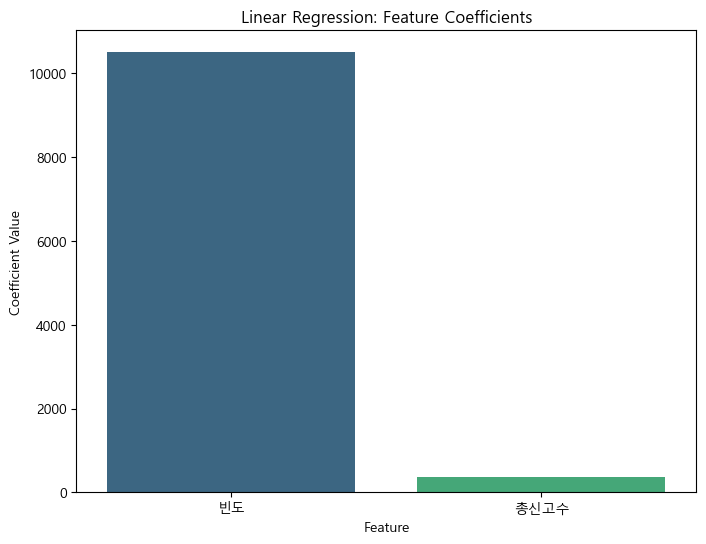

In [29]:
plt.figure(figsize=(8, 6))
sns.barplot(data=coef_df.sort_values(by='Absolute Coefficient', ascending=False),
            x='Feature', y='Coefficient', palette='viridis')
plt.title('Linear Regression: Feature Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.show()


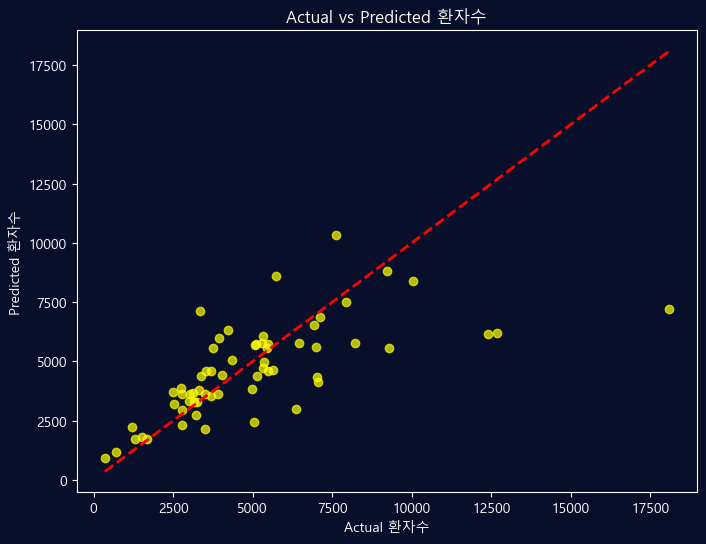

In [66]:
# Figure와 Axes 객체 생성
fig, ax = plt.subplots(figsize=(8, 6))

# Figure 배경색 설정
fig.patch.set_facecolor('#070F2B')

# Axes 배경색 설정
ax.set_facecolor('none')

ax.scatter(y_test, y_pred, alpha=0.7, edgecolor='yellow', color='yellow')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax.set_xlabel('Actual 환자수', color="white")
ax.set_ylabel('Predicted 환자수', color="white")
ax.set_title('Actual vs Predicted 환자수', color="white")

# # 테두리 선 색상 설정
for spine in ax.spines.values():
    spine.set_edgecolor('white')

# X, Y 축 눈금과 눈금 레이블 색상 설정
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()


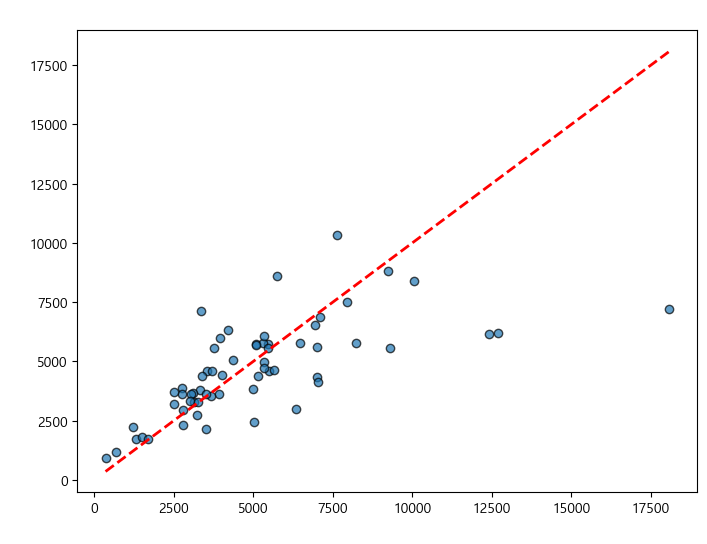

In [43]:
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_facecolor((0, 0, 0, 0))

plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('실제환자 수', color="white")
plt.ylabel('예측환자 수', color="white")
plt.title('회귀식 도출결과', color="white")
plt.show()

c:\data_analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


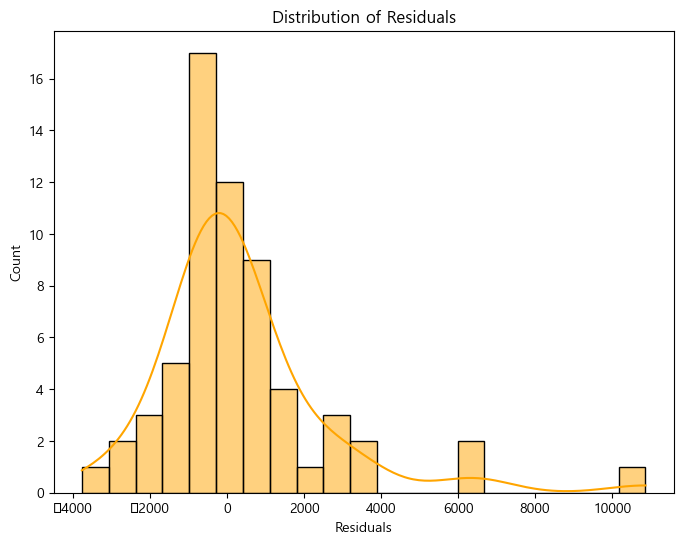

In [31]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='orange')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

In [14]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 5152266.270380136
R^2 Score: 0.43748811094145046


In [15]:
# 4-1. RandomForestRegressor 모델 학습 및 예측
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

y1_pred = rf_model.predict(X_test)

In [16]:
mse = mean_squared_error(y_test, y1_pred)
r2 = r2_score(y_test, y1_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 5215630.8070129035
R^2 Score: 0.43057012508238734
